# Data Quality Audit

Comprehensive analysis of feature engineering pipeline data quality:
- Data types and memory efficiency
- Extreme outliers and impossible values
- Near-zero division issues
- Categorical feature handling
- Missing value patterns

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

PROJ_ROOT = Path.cwd().parent
if str(PROJ_ROOT) not in sys.path:
    sys.path.append(str(PROJ_ROOT))

from credit_risk_xai.config import FEATURE_CACHE_PATH, FEATURES_FOR_MODEL, CATEGORICAL_COLS
from credit_risk_xai.features.engineer import prepare_modeling_data

# Plotting settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

## 1. Load Data and Basic Overview

In [2]:
# Load feature-engineered dataset
df = pd.read_parquet(FEATURE_CACHE_PATH)

# Apply standard filters
df_filtered = df[
    (df['ser_aktiv'] == 1) & 
    (df['sme_category'].isin(['Small', 'Medium'])) & 
    (df['knc_kncfall'] == 1)
]

print(f"Total records: {len(df):,}")
print(f"After filters: {len(df_filtered):,}")
print(f"\nMemory usage:")
print(f"  Full dataset: {df.memory_usage(deep=True).sum() / 1024**3:.2f} GB")
print(f"  Filtered: {df_filtered.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Get modeling features
X, y = prepare_modeling_data(df_filtered)
print(f"\nModeling data: {len(X):,} rows × {len(X.columns)} features")
print(f"Target distribution: {y.value_counts().to_dict()}")

Total records: 12,473,668
After filters: 341,134

Memory usage:
  Full dataset: 4.27 GB
  Filtered: 123.28 MB

Modeling data: 316,663 rows × 40 features
Target distribution: {np.int8(0): 310079, np.int8(1): 6584}


## 2. Data Type Analysis

In [3]:
print("=" * 100)
print("DATA TYPE ANALYSIS")
print("=" * 100)

# Analyze dtypes
dtype_summary = X.dtypes.value_counts()
print("\nData type distribution:")
print(dtype_summary)

# Check categorical dtypes
print("\n" + "-" * 100)
print("CATEGORICAL FEATURES ANALYSIS")
print("-" * 100)

categorical_status = []
for col in CATEGORICAL_COLS:
    if col in X.columns:
        is_category = X[col].dtype.name == 'category'
        n_unique = X[col].nunique()
        categorical_status.append({
            'feature': col,
            'current_dtype': str(X[col].dtype),
            'is_category': '✓' if is_category else '✗',
            'unique_values': n_unique,
            'null_pct': f"{100 * X[col].isna().sum() / len(X):.1f}%"
        })

cat_df = pd.DataFrame(categorical_status)
print(cat_df.to_string(index=False))

# Dtype efficiency check
print("\n" + "-" * 100)
print("DTYPE EFFICIENCY ISSUES")
print("-" * 100)

for col in X.columns:
    dtype = X[col].dtype
    
    # Check if using oversized int
    if dtype == 'Int16' or dtype == 'int16':
        min_val, max_val = X[col].min(), X[col].max()
        if min_val >= 0 and max_val <= 255:
            print(f"  {col}: Using {dtype}, but range [{min_val}, {max_val}] fits in uint8")
    
    # Check if using float64 unnecessarily
    if dtype == 'float64':
        print(f"  {col}: Using float64 (could use float32 if precision not critical)")

DATA TYPE ANALYSIS

Data type distribution:
float32     37
Int16        1
category     1
uint8        1
Name: count, dtype: int64

----------------------------------------------------------------------------------------------------
CATEGORICAL FEATURES ANALYSIS
----------------------------------------------------------------------------------------------------
            feature current_dtype is_category  unique_values null_pct
bransch_sni071_konv      category           ✓            750     0.0%

----------------------------------------------------------------------------------------------------
DTYPE EFFICIENCY ISSUES
----------------------------------------------------------------------------------------------------
  company_age: Using Int16, but range [0, 155] fits in uint8


## 3. Feature Distribution Analysis

In [4]:
print("=" * 100)
print("DESCRIPTIVE STATISTICS (All Features)")
print("=" * 100)

# Get numeric columns only
numeric_cols = X.select_dtypes(include=[np.number]).columns
desc = X[numeric_cols].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).T

# Add null percentage
desc['null_pct'] = 100 * X[numeric_cols].isna().sum() / len(X)

# Add outlier count (beyond 5 std devs)
outlier_counts = []
for col in numeric_cols:
    values = X[col].dropna()
    if len(values) > 0:
        mean, std = values.mean(), values.std()
        if std > 0:
            outliers = (np.abs(values - mean) > 5 * std).sum()
        else:
            outliers = 0
    else:
        outliers = 0
    outlier_counts.append(outliers)

desc['outliers_5std'] = outlier_counts

print(desc.to_string())

DESCRIPTIVE STATISTICS (All Features)
                                   count         mean           std           min            1%         5%        25%        50%        75%           95%           99%           max   null_pct  outliers_5std
company_age                     316663.0    16.158822     14.170954           0.0           0.0        1.0        6.0       12.0       22.0          44.0          64.0         155.0   0.000000            739
ny_kapomsh                      316580.0     3.007218      44.97625           0.0      0.105611   0.634699   1.526489   2.404384   3.581129      6.564929     10.170048       17743.0   0.026211             11
ny_rs                           316495.0     0.056635      7.662149     -0.000006           0.0        0.0   0.002528   0.012045    0.02744      0.058005      0.147204   3150.600098   0.053053             22
ny_skuldgrd                     303334.0     9.132657    323.417267 -12658.608398      0.108042   0.340034   0.990363   2.038015  

## 4. Near-Zero Division Issues

Identify features with extreme values likely caused by division by near-zero denominators.

In [5]:
print("=" * 100)
print("NEAR-ZERO DIVISION ANALYSIS")
print("=" * 100)

# Features known to have division operations
division_features = {
    'dso_days': {'numerator': 'br06g_kfordsu', 'denominator': 'rr01_ntoms', 'reasonable_range': (0, 365)},
    'dpo_days': {'numerator': 'br13a_ksklev', 'denominator': 'rr06a_prodkos', 'reasonable_range': (0, 365)},
    'ratio_cash_liquidity': {'numerator': 'br08_omstgsu', 'denominator': 'br13_ksksu', 'reasonable_range': (0, 10)},
    'ratio_cash_interest_cov': {'numerator': None, 'denominator': None, 'reasonable_range': (-100, 100)},
    'rr07_rorresul_yoy_pct': {'numerator': None, 'denominator': 'prev_year_value', 'reasonable_range': (-100, 100)},
    'ratio_cash_liquidity_yoy_pct': {'numerator': None, 'denominator': 'prev_year_value', 'reasonable_range': (-100, 100)},
    'current_ratio_yoy_pct': {'numerator': None, 'denominator': 'prev_year_value', 'reasonable_range': (-100, 100)},
}

for feature, info in division_features.items():
    if feature not in X.columns:
        continue
    
    print(f"\n{feature}:")
    print("-" * 80)
    
    values = X[feature].dropna()
    
    # Basic stats
    print(f"  Count: {len(values):,} | Null: {X[feature].isna().sum():,} ({100*X[feature].isna().sum()/len(X):.1f}%)")
    print(f"  Min: {values.min():.2f} | Max: {values.max():.2f}")
    print(f"  Mean: {values.mean():.2f} | Median: {values.median():.2f}")
    print(f"  P1: {values.quantile(0.01):.2f} | P99: {values.quantile(0.99):.2f}")
    
    # Check reasonable range
    reasonable_min, reasonable_max = info['reasonable_range']
    in_range = (values >= reasonable_min) & (values <= reasonable_max)
    pct_in_range = 100 * in_range.sum() / len(values)
    
    print(f"  In reasonable range [{reasonable_min}, {reasonable_max}]: {pct_in_range:.1f}%")
    print(f"  Outside reasonable range: {(~in_range).sum():,} obs ({100*(~in_range).sum()/len(values):.1f}%)")
    
    # Extreme values
    extreme_low = values < (reasonable_min - 1000)
    extreme_high = values > (reasonable_max + 1000)
    
    if extreme_low.sum() > 0:
        print(f"  ⚠ EXTREME LOW (<{reasonable_min - 1000}): {extreme_low.sum():,} obs")
        print(f"    Worst 5: {values[extreme_low].nsmallest(5).values}")
    
    if extreme_high.sum() > 0:
        print(f"  ⚠ EXTREME HIGH (>{reasonable_max + 1000}): {extreme_high.sum():,} obs")
        print(f"    Worst 5: {values[extreme_high].nlargest(5).values}")

NEAR-ZERO DIVISION ANALYSIS

dso_days:
--------------------------------------------------------------------------------
  Count: 313,995 | Null: 2,668 (0.8%)
  Min: -29.92 | Max: 730.00
  Mean: 59.35 | Median: 51.07
  P1: 1.92 | P99: 308.33
  In reasonable range [0, 365]: 99.3%
  Outside reasonable range: 2,273 obs (0.7%)

dpo_days:
--------------------------------------------------------------------------------
  Count: 124,467 | Null: 192,196 (60.7%)
  Min: -30.00 | Max: 212.27
  Mean: -16.77 | Median: -18.10
  P1: -29.78 | P99: 0.00
  In reasonable range [0, 365]: 5.9%
  Outside reasonable range: 117,144 obs (94.1%)

ratio_cash_liquidity:
--------------------------------------------------------------------------------
  Count: 315,692 | Null: 971 (0.3%)
  Min: -0.00 | Max: 98.97
  Mean: 0.78 | Median: 0.36
  P1: 0.00 | P99: 6.38
  In reasonable range [0, 10]: 99.5%
  Outside reasonable range: 1,598 obs (0.5%)

ratio_cash_interest_cov:
------------------------------------------------

## 5. Denominator Analysis

Check the distributions of denominators to understand near-zero division issues.

In [6]:
print("=" * 100)
print("DENOMINATOR ANALYSIS (for division-based features)")
print("=" * 100)

# Check key denominators
denominators = {
    'rr01_ntoms': 'Revenue (used in DSO calculation)',
    'rr06a_prodkos': 'Production costs (used in DPO calculation)',
    'br13_ksksu': 'Current liabilities (used in cash liquidity ratio)',
}

for denom_col, description in denominators.items():
    if denom_col not in df_filtered.columns:
        continue
    
    print(f"\n{denom_col}: {description}")
    print("-" * 80)
    
    values = df_filtered[denom_col].dropna()
    
    # Basic stats
    print(f"  Count: {len(values):,}")
    print(f"  Min: {values.min():.2f} | Max: {values.max():.2f}")
    print(f"  Mean: {values.mean():.2f} | Median: {values.median():.2f}")
    
    # Check for near-zero and negative
    zero_count = (values == 0).sum()
    near_zero_1 = (values.abs() < 1).sum()
    near_zero_10 = (values.abs() < 10).sum()
    negative = (values < 0).sum()
    
    print(f"\n  Zero: {zero_count:,} ({100*zero_count/len(values):.2f}%)")
    print(f"  |value| < 1: {near_zero_1:,} ({100*near_zero_1/len(values):.2f}%)")
    print(f"  |value| < 10: {near_zero_10:,} ({100*near_zero_10/len(values):.2f}%)")
    print(f"  Negative: {negative:,} ({100*negative/len(values):.2f}%)")
    
    # Recommended threshold
    if 'ntoms' in denom_col:  # Revenue
        threshold = 10.0
    else:
        threshold = 1.0
    
    below_threshold = (values.abs() < threshold).sum()
    print(f"\n  ⚠ WOULD EXCLUDE with threshold={threshold}: {below_threshold:,} ({100*below_threshold/len(values):.1f}%)")

DENOMINATOR ANALYSIS (for division-based features)

rr01_ntoms: Revenue (used in DSO calculation)
--------------------------------------------------------------------------------
  Count: 341,126
  Min: 0.00 | Max: 11403721.00
  Mean: 36412.36 | Median: 18232.00

  Zero: 564 (0.17%)
  |value| < 1: 564 (0.17%)
  |value| < 10: 625 (0.18%)
  Negative: 0 (0.00%)

  ⚠ WOULD EXCLUDE with threshold=10.0: 625 (0.2%)


## 6. Visualization: Extreme Value Distributions

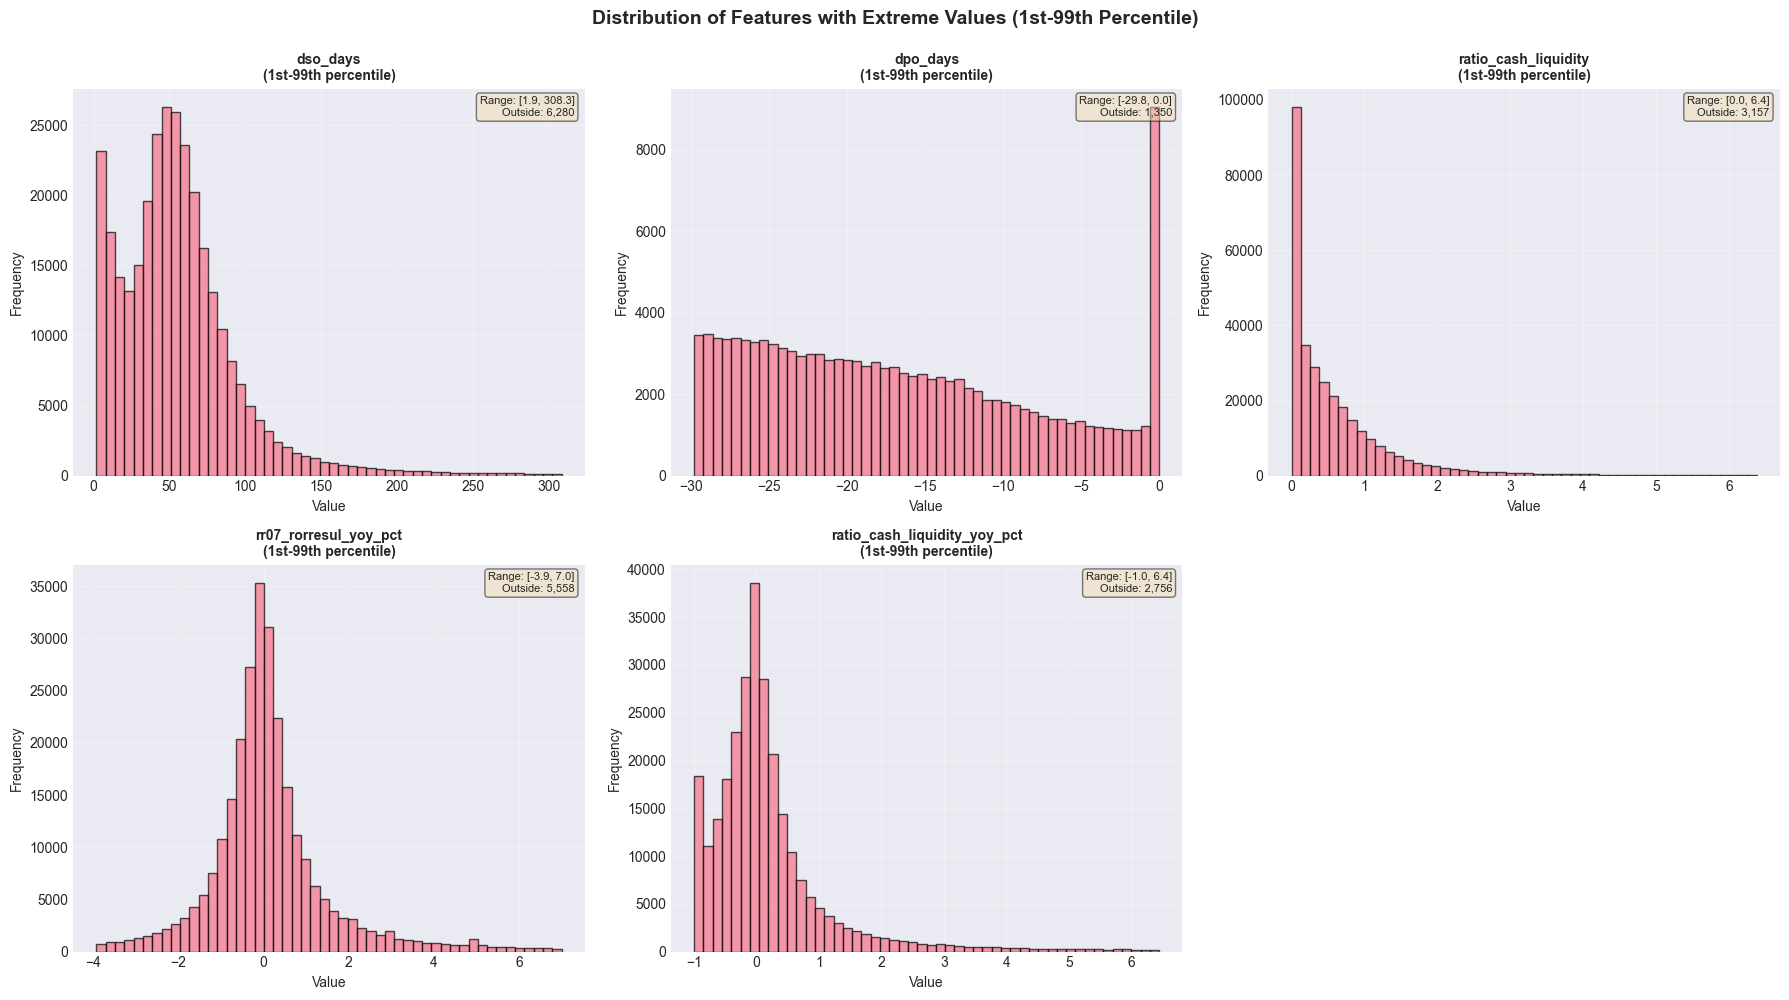

In [7]:
# Plot distributions of problematic features
problematic_features = [
    'dso_days', 'dpo_days', 'ratio_cash_liquidity', 
    'rr07_rorresul_yoy_pct', 'ratio_cash_liquidity_yoy_pct'
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, feature in enumerate(problematic_features):
    if feature not in X.columns or idx >= len(axes):
        continue
    
    ax = axes[idx]
    values = X[feature].dropna()
    
    # Use percentile range for visualization
    p1, p99 = values.quantile([0.01, 0.99])
    filtered_values = values[(values >= p1) & (values <= p99)]
    
    # Histogram
    ax.hist(filtered_values, bins=50, alpha=0.7, edgecolor='black')
    ax.set_title(f'{feature}\n(1st-99th percentile)', fontsize=10, fontweight='bold')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.grid(alpha=0.3)
    
    # Add stats text
    stats_text = f"Range: [{p1:.1f}, {p99:.1f}]\nOutside: {(~values.between(p1, p99)).sum():,}"
    ax.text(0.98, 0.98, stats_text, transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            fontsize=8)

# Hide extra subplot
if len(problematic_features) < len(axes):
    axes[-1].axis('off')

plt.suptitle('Distribution of Features with Extreme Values (1st-99th Percentile)',
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

## 7. Summary and Recommendations

In [8]:
print("="*100)
print("SUMMARY: REQUIRED FIXES")
print("="*100)

print("\n1. CATEGORICAL DTYPES")
print("-" * 80)
cat_not_encoded = [col for col in CATEGORICAL_COLS if col in X.columns and X[col].dtype.name != 'category']
if cat_not_encoded:
    print(f"  ✗ {len(cat_not_encoded)} categorical features not using category dtype:")
    for col in cat_not_encoded:
        print(f"    - {col}: {X[col].dtype}")
else:
    print("  ✓ All categorical features properly encoded")

print("\n2. NEAR-ZERO DIVISION ISSUES")
print("-" * 80)
print("  Recommend implementing threshold-based NaN conversion in _safe_div():")
print("    - min_abs_denom=1.0 for most ratios (1k SEK)")
print("    - min_abs_denom=10.0 for revenue-based metrics (10k SEK)")
print("\n  Expected impact:")

# Estimate impact for key denominators
if 'rr01_ntoms' in df_filtered.columns:
    revenue_below_10 = (df_filtered['rr01_ntoms'].abs() < 10).sum()
    print(f"    - DSO: ~{100*revenue_below_10/len(df_filtered):.1f}% → NaN (revenue < 10k)")

if 'rr06a_prodkos' in df_filtered.columns:
    prodcost_below_1 = (df_filtered['rr06a_prodkos'].abs() < 1).sum()
    print(f"    - DPO: ~{100*prodcost_below_1/len(df_filtered):.1f}% → NaN (prod costs < 1k)")

if 'br13_ksksu' in df_filtered.columns:
    liab_below_1 = (df_filtered['br13_ksksu'].abs() < 1).sum()
    print(f"    - Cash liquidity ratio: ~{100*liab_below_1/len(df_filtered):.1f}% → NaN (liabilities < 1k)")

print("\n3. DATA TYPE OPTIMIZATION")
print("-" * 80)
if 'event_count_last_5y' in X.columns:
    print(f"  • event_count_last_5y: {X['event_count_last_5y'].dtype} → uint8 (range 0-5)")
float64_cols = [col for col in X.columns if X[col].dtype == 'float64']
if float64_cols:
    print(f"  • {len(float64_cols)} features using float64 could use float32")

print("\n" + "="*100)
print("\n✓ Data quality audit complete. Proceed with fixes in engineer.py")

SUMMARY: REQUIRED FIXES

1. CATEGORICAL DTYPES
--------------------------------------------------------------------------------
  ✓ All categorical features properly encoded

2. NEAR-ZERO DIVISION ISSUES
--------------------------------------------------------------------------------
  Recommend implementing threshold-based NaN conversion in _safe_div():
    - min_abs_denom=1.0 for most ratios (1k SEK)
    - min_abs_denom=10.0 for revenue-based metrics (10k SEK)

  Expected impact:
    - DSO: ~0.2% → NaN (revenue < 10k)

3. DATA TYPE OPTIMIZATION
--------------------------------------------------------------------------------
  • event_count_last_5y: uint8 → uint8 (range 0-5)


✓ Data quality audit complete. Proceed with fixes in engineer.py
